<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#LinearRegressor" data-toc-modified-id="LinearRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegressor</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGMB" data-toc-modified-id="LightGMB-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGMB</a></span></li><li><span><a href="#Итог" data-toc-modified-id="Итог-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Итог</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer


from statsmodels.tsa.seasonal import seasonal_decompose

import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

## Подготовка

In [2]:
data = pd.read_csv("/datasets/taxi.csv",index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
data.sort_index(inplace=True)
data_resample = data.resample('1H').sum()
data_resample.index.is_monotonic

True

In [6]:
data_resample.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные упорядочны

In [7]:
data_resample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Добавим скользящее среднее на график:

In [8]:
data_rolling_mean = data.copy()

In [9]:
data_rolling_mean['rolling_mean'] = data_rolling_mean.rolling(100, closed = 'left').mean()

In [10]:
data_resample_rolling_mean = data_resample.copy()

In [11]:
data_resample_rolling_mean['rolling_mean'] = data_resample_rolling_mean.rolling(100, closed='left').mean()

Построим график с интервалом в 10 минут

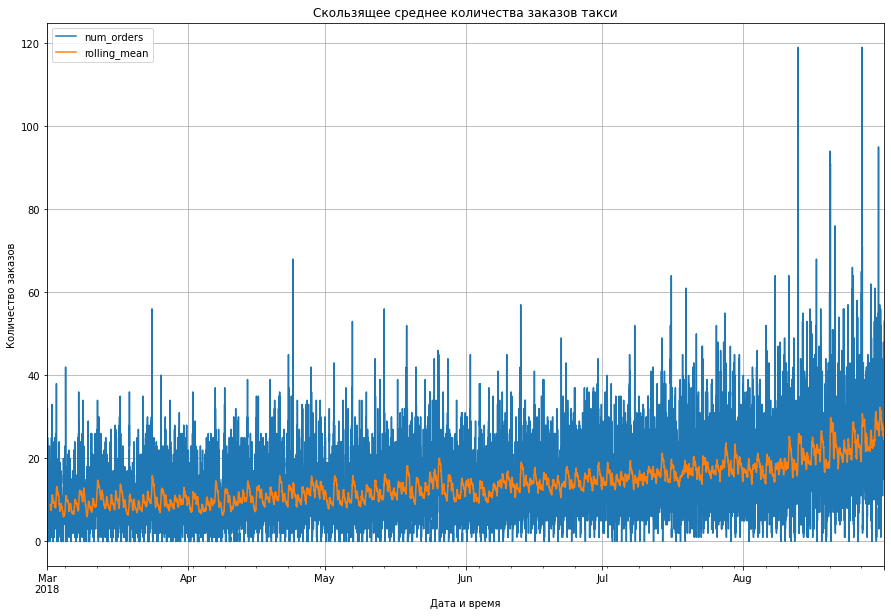

In [12]:
data_rolling_mean.plot(figsize = (15,10), grid = True)
plt.title('Скользящее среднее количества заказов такси')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.show()

Трудно сказать по графику какие-то выводы. Имеются небольшие пики. Чем ближе к концу графика, тем больше виден спрос на такси. Скользящее среднее постоянно колеблится, но к концу видно рост

Посмотрим на график с интервалом в 1 час

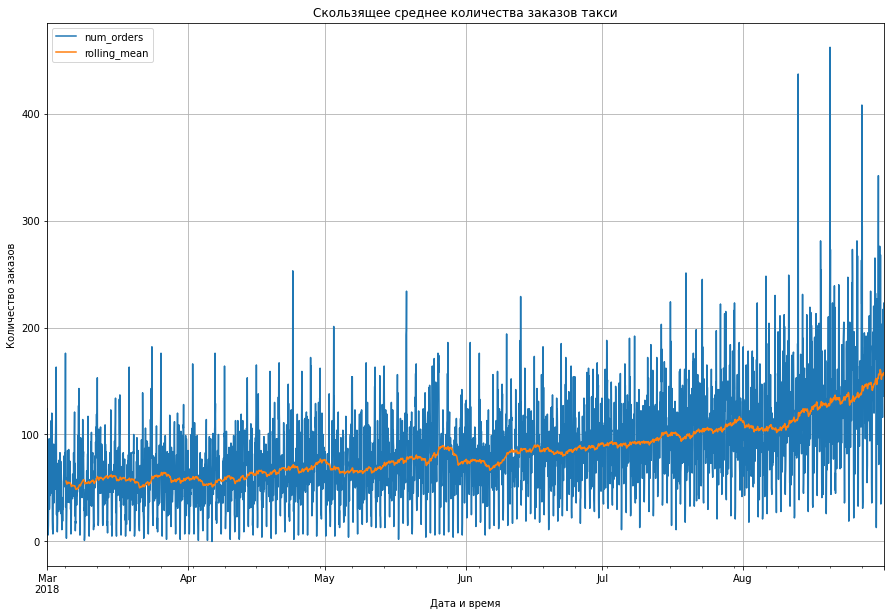

In [13]:
data_resample_rolling_mean.plot(figsize = (15,10), grid = True)
plt.title('Скользящее среднее количества заказов такси')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.show()

Ситуация аналагична графику с 10 минутами. Но скользящая средняя более гладкая и увеличивается со временем.

Рассмотрим данные более детально.

In [14]:
decomposed_data = seasonal_decompose(data_resample)

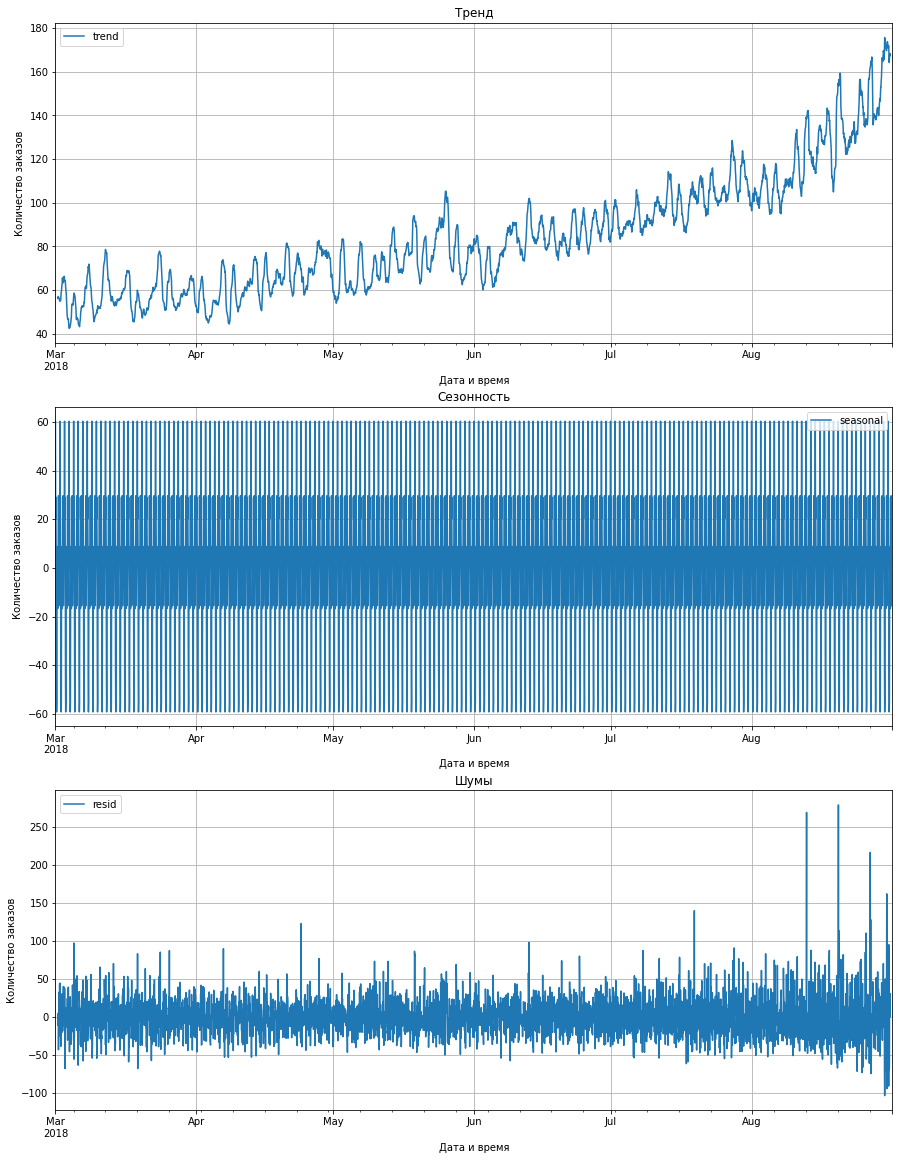

In [15]:
fig , ax = plt.subplots(1,3, figsize=(15,20))

#Тренд
plt.subplot(3,1,1)
decomposed_data.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend(), plt.grid()
#Сезонность
plt.subplot(3,1,2)
decomposed_data.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend(), plt.grid()
#Residuals
plt.subplot(3,1,3)
decomposed_data.resid.plot(ax=plt.gca())
plt.title('Шумы')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend(), plt.grid()
plt.show()

График тренда показывает возрастающую зависимость к августу. Это обусловлено ростом отпусков у людей.

График сезонности трудно читается. Рассмотрим его более детально (График по недели и день).

График остатка декомпозиции особо ничего не показывает

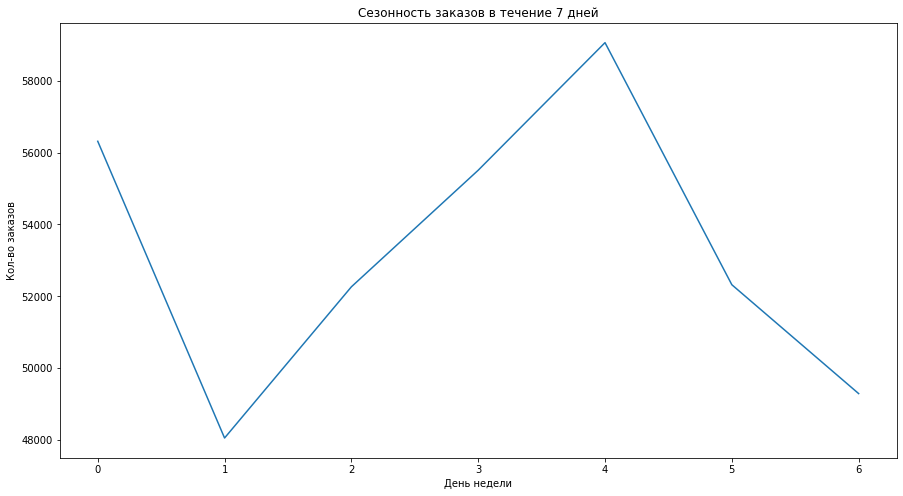

In [16]:
#создадим признаки с днем недели, часом
data_resample['dayofweek'] = data_resample.index.dayofweek
data_resample['hour'] = data_resample.index.hour
#Построим графики количества заказов
plt.figure(figsize=(15,8))
data_resample.groupby('dayofweek')['num_orders'].sum().plot();
plt.title('Сезонность заказов в течение 7 дней');
plt.ylabel('Кол-во заказов');
plt.xlabel('День недели')
plt.subplots_adjust(wspace=0.5,hspace = 0.5);



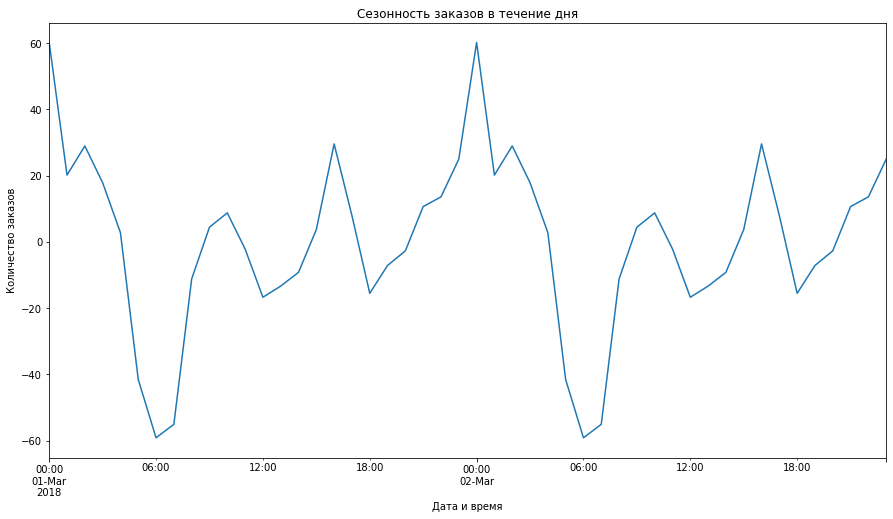

In [17]:
plt.figure(figsize=(15,8))
plt.title("Сезонность заказов в течение дня")
decomposed_data.seasonal['2018-03-01':'2018-03-02'].plot()
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.xlabel('Дата и время')
plt.show()

Попробую сделать вывод по графикам:

График(Сезонность заказов в течение 7 дней) по дням недели: имеет 2 пика - пятница, понедельник.
понедельник - возвращение людей после выходных(или наоборот прилетают на работу), далее спад и снова рост к пятнице - улетают на выходные.

Сезонность заказов в течение дня: увеличивается кол-во заказова с 06:00 и до полуночи. Затем спад до 5 утра.
Т.к. имеется зависимость от дня недели то 24*7 = 168 - это число для лага

## Обучение

### Подготовка данных

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['weekday'] = data.index.weekday
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [19]:
make_features(data_resample, 168, 168)

In [20]:
data_resample.head()

,num_orders,dayofweek,hour,day,weekday,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
train, valid = train_test_split(data_resample, shuffle=False, test_size=0.1)
valid, test = train_test_split(valid, shuffle=False, test_size=0.5)
train = train.dropna()

In [22]:
features_train = train.drop(columns=['num_orders'])
target_train = train['num_orders']

features_valid = valid.drop(columns=['num_orders'])
target_valid = valid['num_orders']

features_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']

In [23]:
data_resample.shape

(4416, 174)

In [24]:
features_train.shape

(3806, 173)

In [25]:
features_valid.shape

(221, 173)

In [26]:
features_test.shape

(221, 173)

### LinearRegressor

In [27]:
model = LinearRegression()
start_time = time.time()
model.fit(features_train, target_train)
time_lr_fit = time.time() - start_time

predict_lr = model.predict(features_valid)
rmse_lr = mean_squared_error(target_valid, predict_lr) ** 0.5
time_lr = time.time() -  start_time

print('RMSE LinearRegression:', rmse_lr)

RMSE LinearRegression: 32.33289650378027


### CatBoost

In [28]:
cat_model = CatBoostRegressor(loss_function="RMSE", iterations=600, random_state=42)
start_time = time.time()
cat_model.fit(features_train, target_train, verbose=5)
time_cat_fit = time.time() - start_time

predict_cat = cat_model.predict(features_valid)
score_cat = mean_squared_error(target_valid, predict_cat) ** 0.5
time_cat = time.time() -  start_time

print("RMSE CatBoostRegressor:", score_cat)
print("Время обучения:",time_cat_fit)
print("Время выполнения:",time_cat)

Learning rate set to 0.076605
0:	learn: 37.0524151	total: 164ms	remaining: 1m 38s
5:	learn: 30.8000172	total: 575ms	remaining: 56.9s
10:	learn: 26.8418981	total: 893ms	remaining: 47.8s
15:	learn: 24.3875400	total: 1.26s	remaining: 46s
20:	learn: 22.9085152	total: 1.58s	remaining: 43.6s
25:	learn: 21.9443728	total: 1.88s	remaining: 41.4s
30:	learn: 21.2762465	total: 2.19s	remaining: 40.2s
35:	learn: 20.7771791	total: 2.52s	remaining: 39.4s
40:	learn: 20.3793432	total: 2.91s	remaining: 39.6s
45:	learn: 20.1514713	total: 3.24s	remaining: 39s
50:	learn: 19.9126928	total: 3.4s	remaining: 36.6s
55:	learn: 19.6895632	total: 3.57s	remaining: 34.7s
60:	learn: 19.5171794	total: 3.74s	remaining: 33.1s
65:	learn: 19.3778685	total: 3.9s	remaining: 31.6s
70:	learn: 19.2128277	total: 4.06s	remaining: 30.3s
75:	learn: 19.0433975	total: 4.23s	remaining: 29.1s
80:	learn: 18.9148145	total: 4.4s	remaining: 28.2s
85:	learn: 18.7851318	total: 4.57s	remaining: 27.3s
90:	learn: 18.6461055	total: 4.74s	remaini

### LightGMB

In [29]:
num_leaves_options = [20, 40, 60]
learning_rate_options = [0.01, 0.1, 0.2]
n_estimators_options = [100, 200, 300]

# Списки для хранения результатов
best_score = float('inf')
best_params = {}
results = []

# Перебор всех комбинаций гиперпараметров
for num_leaves, learning_rate, n_estimators in itertools.product(num_leaves_options, learning_rate_options, n_estimators_options):
    # Обучение модели
    lgbm_model = LGBMRegressor(num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=n_estimators, random_state=42)
    start_time = time.time()
    lgbm_model.fit(features_train, target_train)
    time_lgbm_fit = time.time() - start_time

    # Прогнозирование и оценка модели
    predict_lgbm = lgbm_model.predict(features_valid)
    score_lgbm = mean_squared_error(target_valid, predict_lgbm) ** 0.5
    time_lgbm = time.time() - start_time

    # Сохранение результатов
    results.append({
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'n_estimators': n_estimators,
        'RMSE': score_lgbm,
        'time_fit': time_lgbm_fit,
        'time_total': time_lgbm
    })

    # Обновление наилучших параметров
    if score_lgbm < best_score:
        best_score = score_lgbm
        best_params = {
            'num_leaves': num_leaves,
            'learning_rate': learning_rate,
            'n_estimators': n_estimators
        }

    print(f"Параметры: num_leaves={num_leaves}, learning_rate={learning_rate}, n_estimators={n_estimators}")
    print(f"RMSE: {score_lgbm}")
    print(f"Время обучения: {time_lgbm_fit}")
    print(f"Время выполнения: {time_lgbm}")

print("\nЛучшие параметры:")
print(best_params)
print(f"Лучший RMSE: {best_score}")

Параметры: num_leaves=20, learning_rate=0.01, n_estimators=100
RMSE: 48.04018567004872
Время обучения: 4.580989360809326
Время выполнения: 4.584776163101196
Параметры: num_leaves=20, learning_rate=0.01, n_estimators=200
RMSE: 39.082518757058814
Время обучения: 8.109910011291504
Время выполнения: 8.11344838142395
Параметры: num_leaves=20, learning_rate=0.01, n_estimators=300
RMSE: 35.94841482827234
Время обучения: 11.887758493423462
Время выполнения: 11.891617774963379
Параметры: num_leaves=20, learning_rate=0.1, n_estimators=100
RMSE: 33.54804674593811
Время обучения: 3.7928755283355713
Время выполнения: 3.796370267868042
Параметры: num_leaves=20, learning_rate=0.1, n_estimators=200
RMSE: 33.66041186324169
Время обучения: 6.401349067687988
Время выполнения: 6.404858589172363
Параметры: num_leaves=20, learning_rate=0.1, n_estimators=300
RMSE: 33.61212311233407
Время обучения: 9.316081285476685
Время выполнения: 9.319608688354492
Параметры: num_leaves=20, learning_rate=0.2, n_estimators=

In [30]:
print(best_score)

33.54804674593811


In [31]:
lgbm_model = LGBMRegressor(num_leaves=20, learning_rate=0.1, n_estimators=100, random_state=42)
start_time = time.time()
lgbm_model.fit(features_train, target_train)
time_lgbm_fit = time.time() - start_time
predict_lgbm = lgbm_model.predict(features_valid)

score_lgbm = mean_squared_error(target_valid, predict_lgbm) ** 0.5
time_lgmb = time.time() -  start_time

print("RMSE LGBMRegressor:", score_lgbm)
print("Время обучения:",time_lgbm_fit)
print("Время выполнения:",time_lgmb)

RMSE LGBMRegressor: 33.54804674593811
Время обучения: 3.20406174659729
Время выполнения: 3.2078194618225098


### Итог

In [32]:
data_itog = pd.DataFrame({"Model":["LinearRegression",
                                   "CatBoost",
                                  "LightGBM"],
                          "RMSE":[rmse_lr,score_cat,score_lgbm],
                          "Fit_time":[time_lr_fit,time_cat_fit,time_lgbm_fit],
                          "Predict_time" :[time_lr,time_cat,time_lgmb]
                         })

In [33]:
data_itog.sort_values(by="RMSE")

,Model,RMSE,Fit_time,Predict_time
0,LinearRegression,32.332897,0.257788,0.357935
2,LightGBM,33.548047,3.204062,3.207819
1,CatBoost,33.677965,22.932004,22.940263


Наилучший результат показала LinearRegression	 модель с RMSE равной 32.332897

Наихудший результат у CatBoost	 (RMSE = 33.677965)

## Тестирование

In [34]:
start_time = time.time()
test_predict = model.predict(features_test)
test_time_predict = time.time() - start_time
score_test = mean_squared_error(target_test, test_predict) ** 0.5
test_time_score = time.time() - start_time
print("RMSE LinearRegression:", score_test)
print("Время обучения:",test_time_predict)
print("Время выполнения:",test_time_score)

RMSE LinearRegression: 36.44078365397685
Время обучения: 0.003217935562133789
Время выполнения: 0.003928661346435547


In [35]:
data_itog = pd.DataFrame({"Model":["LinearRegression",
                                   "CatBoost",
                                  "LightGBM",
                                  "Test_Linear"],
                          "RMSE":[rmse_lr,score_cat,score_lgbm,score_test],
                          "Fit_time":[time_lr_fit,time_cat_fit,time_lgbm_fit,test_time_predict],
                          "Predict_time" :[time_lr,time_cat,time_lgmb,test_time_score]
                         })

In [36]:
data_itog

,Model,RMSE,Fit_time,Predict_time
0,LinearRegression,32.332897,0.257788,0.357935
1,CatBoost,33.677965,22.932004,22.940263
2,LightGBM,33.548047,3.204062,3.207819
3,Test_Linear,36.440784,0.003218,0.003929


# Вывод:
- Были загружены данные. В качестве индекса был выбран столбец с датой и отфильтрован по возрастанию. Данные были ресамплированы по часам;
- Полученные данные были проанализированы. График тренда показывает возрастающую зависимость к августу. Это обусловлено ростом отпусков у людей летом. График сезонности показал, что наибольшая активность людей происходит под вечер-ночь.График остатка декомпозиции особо ничего не показывает
- В таблицу были добавлены новые признаки и обучены на 3х моделей : LightGBM, CatBoost, LinearRegression. Наилучший результат показала Linear модель с RMSE равной 32.341694.
